# AMPD - Automatic Multiscale Peak Detection

This notebook provides an end-to-end pipeline for processing and analyzing fNIRS data collected during a finger-tapping task. The primary goal is to identify peaks in the time series data using an **Optimized AMPD** algorithm.

The **AMPD** algorithm is a multiscale peak detection technique that is especially effective for periodic and quasi-periodic signals, even in the presence of noise. By analyzing the signal at multiple scales, the algorithm can reliably detect local maxima while minimizing false positives. This method is based on the work by Scholkmann et al., which is described in this **[paper](https://doi.org/10.3390/a5040588)**



In [212]:
import cedalion.nirs
from cedalion import units
from cedalion.sigproc import quality
from cedalion.sigproc.frequency import freq_filter
import cedalion.xrutils as xrutils
from cedalion.datasets import get_fingertapping_snirf_path
import time
import numpy as np
import xarray as xr
from cedalion.sigproc.physio import ampd, ampd_orig
import matplotlib.pyplot as plt

xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)

### Loading raw CW-NIRS data from a SNIRF file
This notebook uses a finger-tapping dataset in BIDS layout provided by [Rob Luke](https://github.com/rob-luke/BIDS-NIRS-Tapping). It can can be downloaded via `cedalion.datasets`.

### Load amplitude data from the snirf file and extract the first 60 seconds for further processing

In [213]:
path_to_snirf_file = get_fingertapping_snirf_path()

recordings = cedalion.io.read_snirf(path_to_snirf_file)
rec = recordings[0]  # there is only one NirsElement in this snirf file...
amp = rec["amp"]  # ... which holds amplitude data

# restrict to first 60 seconds and fill in missing units
amp = amp.sel(time=amp.time < 60)
times = amp.time.values * 1000
# print(amp.time.values[-1] / 60, len(times))


### Following are utility methods for normalizing, filtering and plotting the signal

In [214]:

# collection of utility functions

def normalize(sig):
    min_val = np.min(sig)
    max_val = np.max(sig)
    return (sig - min_val) / (max_val - min_val)

def filter_signal(amplitudes):
    return freq_filter(amplitudes, 0.5 * units.Hz, 3 * units.Hz, 2)

def plot_peaks(signal, s_times, s_peaks, label, title='peaks'):
    fig, ax = plt.subplots(1, 1, figsize=(24, 8))
    ax.plot(s_times, signal, label=label)

    for ind, peak in enumerate(s_peaks):
        if peak > 0:
            ax.axvline(x=peak, color='black', linestyle='--', linewidth=1)

    plt.title(title)



### This is the amplitude data structure

In [215]:

amp
# filter the signal to remove noise
# amp = filter_signal(amp)

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0903297 0.090175 0.0899268] [0.1856806 0.186377 0.1836514 ... 0.184885 0.1850145 0.1846866]] [[0.227516 0.2297024 0.2261366 ... 0.2241381 0.2243378 0.2256896] [0.6354927 0.637668 0.6298023 ... 0.6222512 0.6236847 0.627199]] [[0.1064704 0.1066212 0.1053444 ... 0.106494 0.1061651 0.1056465] [0.2755033 0.2761615 0.2727006 ... 0.2736698 0.2742193 0.2759685]] ... [[0.2027881 0.1996586 0.2004866 ... 0.1998214 0.2007051 0.202647] [0.4666358 0.4554404 0.4561614 ... 0.448159 0.4511331 0.4540838]] [[0.4885007 0.4802285 0.4818338 ... 0.5004812 0.5035935 0.5044765] [0.8457658 0.825988 0.8259648 ... 0.8385809 0.8441086 0.8474942]] [[0.6304559 0.6284427 0.6287045 ... 0.637311 0.6379823 0.6392407] [1.2285622 1.2205907 1.2190002 ... 1.2232131 1.2258861 1.2278113]]]
Units,dimensionless


### Now run the *optimized AMPD* on the amplitude data 

In [216]:

# use the optimized AMPD to find the peaks
peaks = ampd(amp)

C:\Users\isawa\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


### Optimized AMPD

The **Optimized AMPD** uses vectorization and data segmentation for improved performance and resource management.


#### Methodology:
1. **Detrending**: Each channel and wavelength signal is first detrended to remove baseline shifts, making peaks easier to detect.
2. **Local Scalogram Matrix (LSM)**: The detrended signal is processed in overlapping chunks. A matrix (LSM) is created to identify regions where local maxima occur across different scales.
3. **Multi-Scale Analysis**: The algorithm analyzes how these maxima behave across scales, accumulating values into a vector \( G \), which helps identify the scale at which peaks are most pronounced.
4. **Peak Identification**: Peaks are identified at locations where the local maxima are consistent across scales, as indicated by low standard deviation values in the LSM.

#### Parameters:
- **`amplitudes`**: An `xarray.DataArray` that contains amplitude data from fnirs signals
- optional **`chunk_size`**: Controls the size of each overlapping segment processed. A larger size can capture more context but may increase computation time.
- optional **`step_size`**: Determines the step increment for the overlapping chunks, controlling how much the segments overlap.

#### Output:
The output, `peaks_xr`, is an `xarray.DataArray` that mirrors the shape and structure of the input data (`amplitudes`). Each detected peak in `peaks_xr` is marked with a `1`, while non-peak values are marked as `0`. This format allows easy access to peak locations across different channels and wavelengths.


In [217]:
peaks

<xarray.DataArray (channel: 28, wavelength: 2, time: 469)> Size: 105kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates: (3/6)
  * time        (time) float64 4kB 0.0 0.128 0.256 0.384 ... 59.65 59.78 59.9
    samples     (time) int32 2kB 0 1 2 3 4 5 6 7 ... 462 463 464 465 466 467 468
    ...          ...
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

### Now plot the signals with the found peaks from the AMPD for Channel S1D1

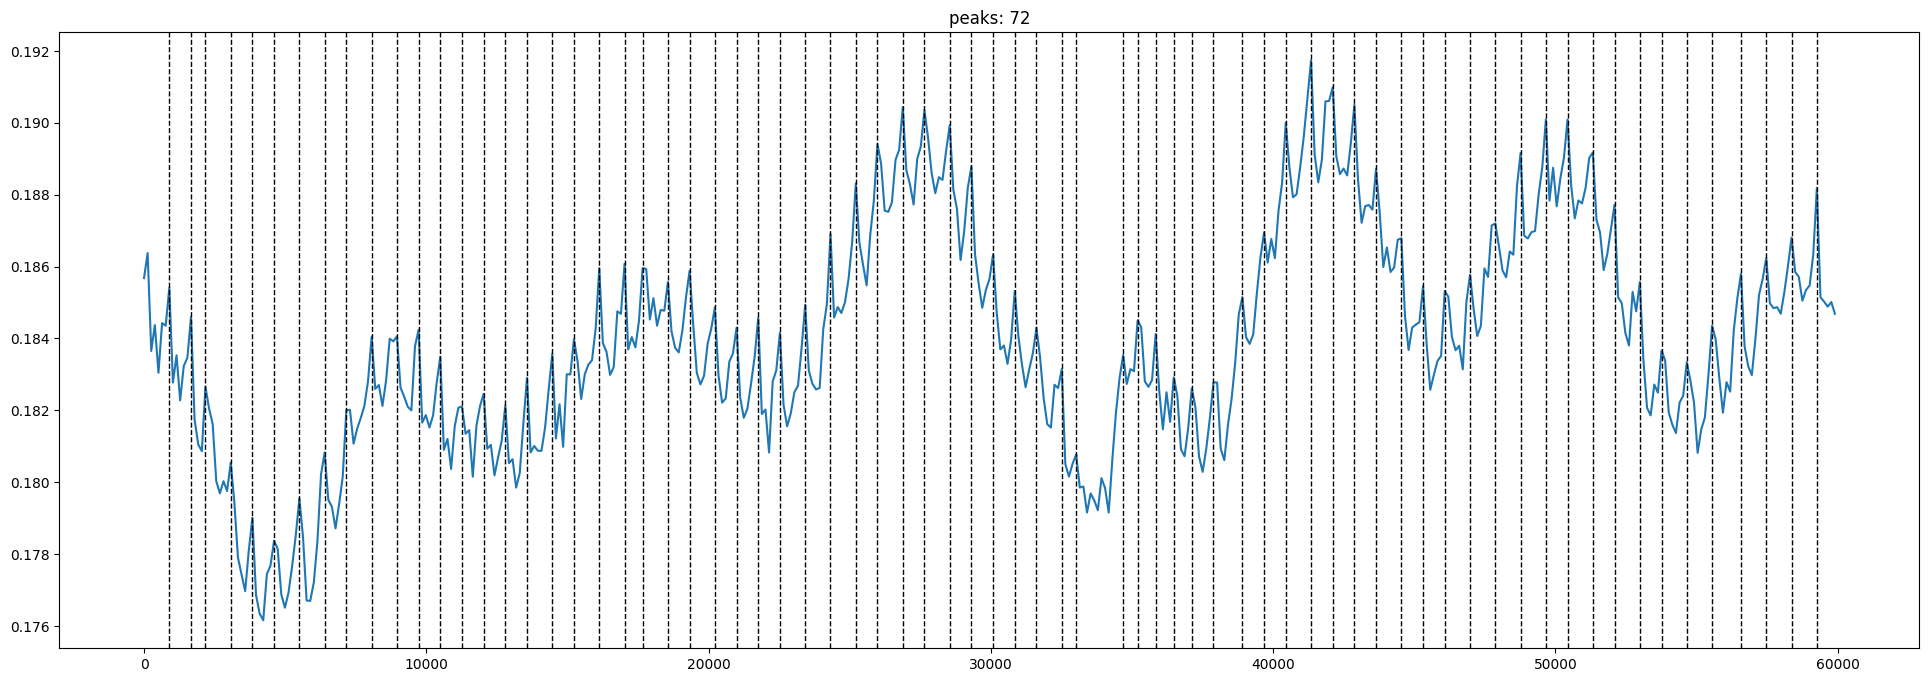

In [218]:

# select a channel for displaying the results
channel = "S1D1"
channel_data = amp.sel(channel=channel)

# retrieve the peaks for that channel. peaks contains lists for the channel and both wavelengths 
# where peaks are represented by 1 and non-peaks are 0
peak_indices = peaks.sel(channel=channel)

# extract the timestamps of the identified peaks for one wavelength
peak_times = times * peak_indices.values[1]
peak_times = [pt for pt in peak_times if pt > 0]

# for plotting prepare the signal for the same wavelength
signal = channel_data.values[1]

# plot the signal and the peaks calculated by the optimized AMPD
plot_peaks(signal, times, peak_times, channel, f"peaks: {len(peak_times)}")
